### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

### Load data

In [3]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
hold_out_set = pd.read_csv('../input/cloud-data-split-v2/hold-out.csv')

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,1f3d231.jpg,NaN,1625401 196 1625598 4 1625607 1 1625612 5 1625...,NaN,NaN,0,1,0,0,train
1,0fa3287.jpg,NaN,121884 511 123284 511 124684 511 126084 511 12...,NaN,32739 369 34139 369 35539 369 36939 369 38339 ...,0,1,0,1,train
2,4d17338.jpg,64 1141 1464 1141 2864 1141 4264 1141 5664 114...,NaN,NaN,13141 707 14541 707 15941 707 17341 707 18741 ...,1,0,0,1,train
3,12e55a8.jpg,NaN,1187509 1060 1188909 1060 1190309 1060 1191709...,NaN,2808 614 4208 614 5608 614 7008 614 8408 614 9...,0,1,0,1,train
4,697eb53.jpg,52180 1006 53580 1006 54980 1006 56380 1006 57...,NaN,NaN,NaN,1,0,0,0,train


# Model parameters

In [4]:
BACKBONE = 'efficientnetb3'
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
model_path = '../input/71-unet-efficientnetb3-onecycle-progressive-learn2/71-unet_efficientnetb3_320x480.h5'
train_images_path = '../input/cloud-images-resized-320x480/train_images320x480/train_images/'

In [5]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [6]:
segmentation_model = load_model(model_path, custom_objects={'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

# Segmentation threshold and mask size tunning

In [7]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500]
threshold_grid = np.arange(.3, 1, .05)
best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed, batch_size=500)

Fish treshold=0.60 mask size=22500 Dice=0.628
Flower treshold=0.60 mask size=12500 Dice=0.760
Gravel treshold=0.65 mask size=20000 Dice=0.616
Sugar treshold=0.35 mask size=15000 Dice=0.582


# Model evaluation

In [8]:
train_metrics = get_metrics(segmentation_model, train, X_train, train_images_path, (HEIGHT, WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Train', batch_size=500)
display(train_metrics)

validation_metrics = get_metrics(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Validation', batch_size=500)
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.489820,0.631579
Flower,0.694714,0.772384
Gravel,0.471012,0.622854
Sugar,0.515631,0.592744
Train,0.542794,0.654890


,Dice,Dice Post
Class,,
Fish,0.469035,0.627716
Flower,0.684288,0.760055
Gravel,0.456260,0.615641
Sugar,0.493572,0.581815
Validation,0.525789,0.646307


## Inspecting some of the validation set predictions

### Without post-process

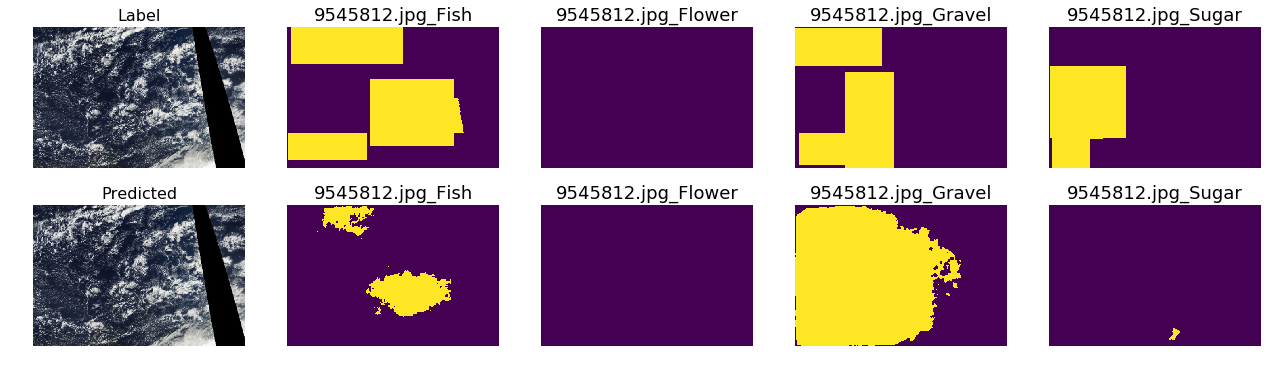

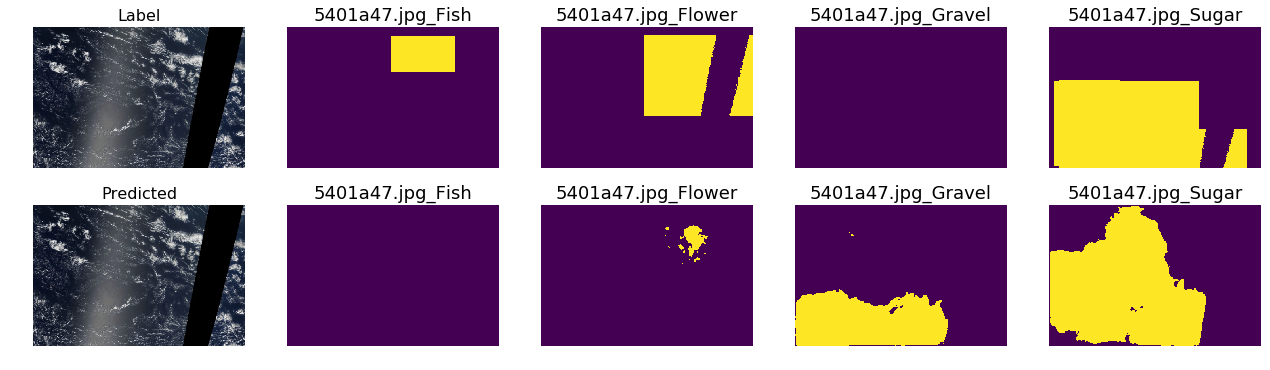

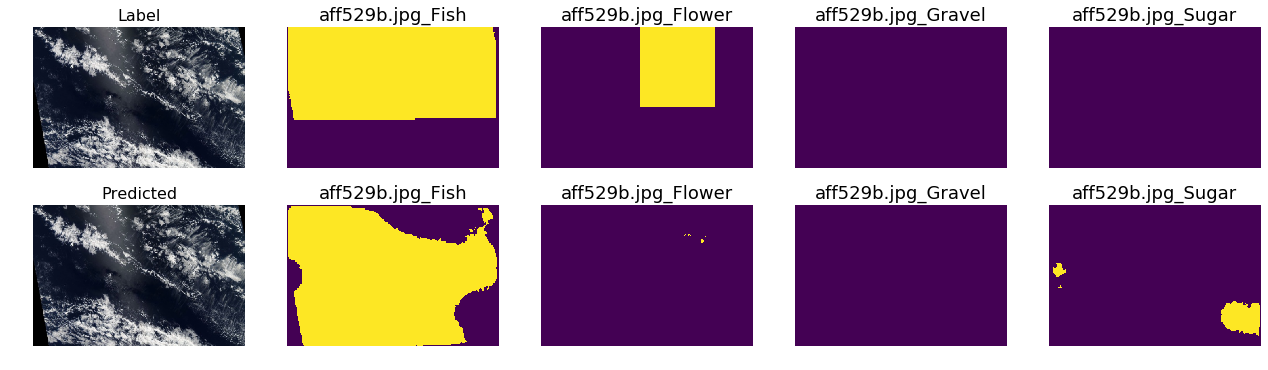

In [9]:
images_to_inspect = np.random.choice(X_val['image'].unique(), 3, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_class = X_val[X_val['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks[..., class_index]
        pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
        pred_masks[...,class_index] = pred_mask

    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[..., class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    
    inspect_set_temp.append(image_df)

inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

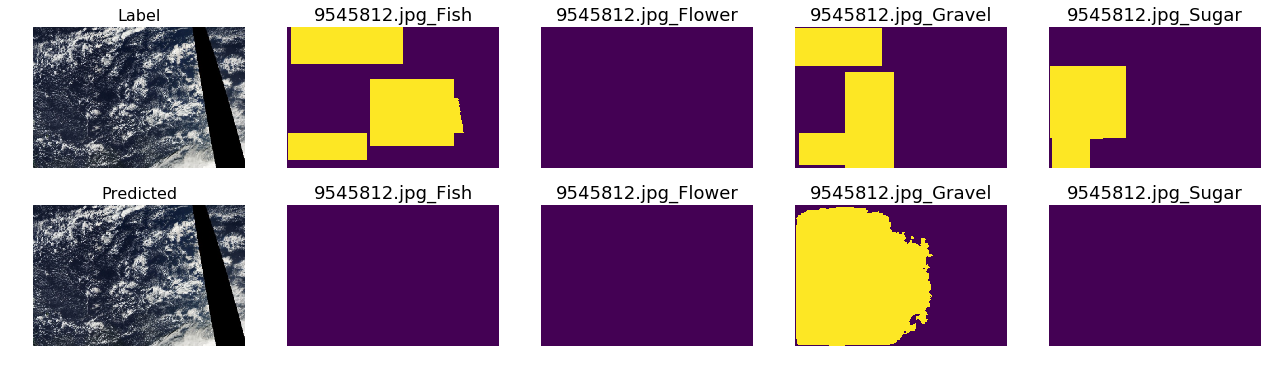

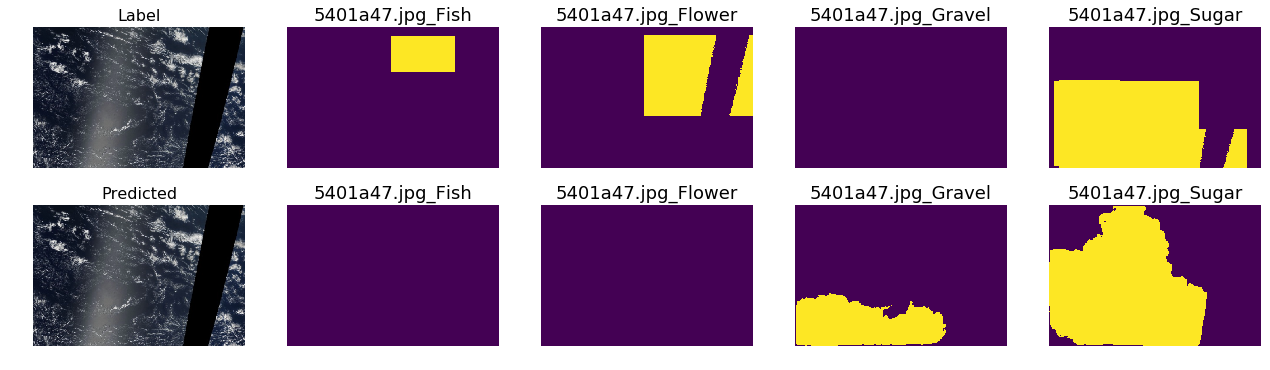

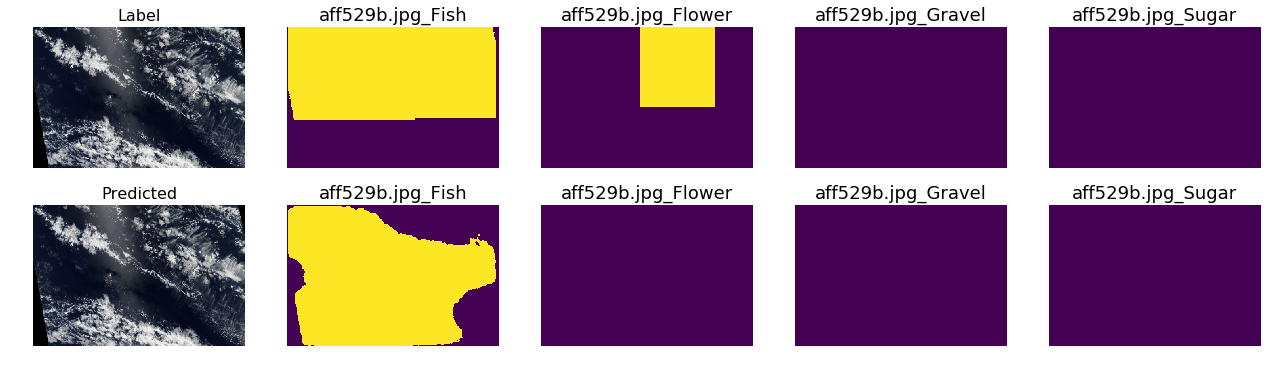

In [10]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')